In [71]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [72]:
# Loading Dataset
train_data = np.loadtxt('Data/TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
train_labels = np.loadtxt('Data/TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')
test_data = np.loadtxt('Data/TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
test_labels = np.loadtxt('Data/TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Feature Selection
tr_samples_size, _ = train_data.shape
all_data = np.vstack((train_data,test_data))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
train_data = all_data[:tr_samples_size]
test_data = all_data[tr_samples_size:]

tr_samples_size, feature_size = train_data.shape
te_samples_size, _ = test_data.shape
print('Train Data Samples:',tr_samples_size,
      ', Test Data Samples',te_samples_size,
      ', Feature Size(after feature-selection):', feature_size)

Train Data Samples: 5000 , Test Data Samples 2500 , Feature Size(after feature-selection): 62


In [81]:
X_train = train_data
X_test = test_data
y_train = train_labels
y_test = test_labels

In [82]:
nbc = GaussianNB()
sfs = SFS(nbc, 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=0)
sfs = sfs.fit(X_train, y_train)

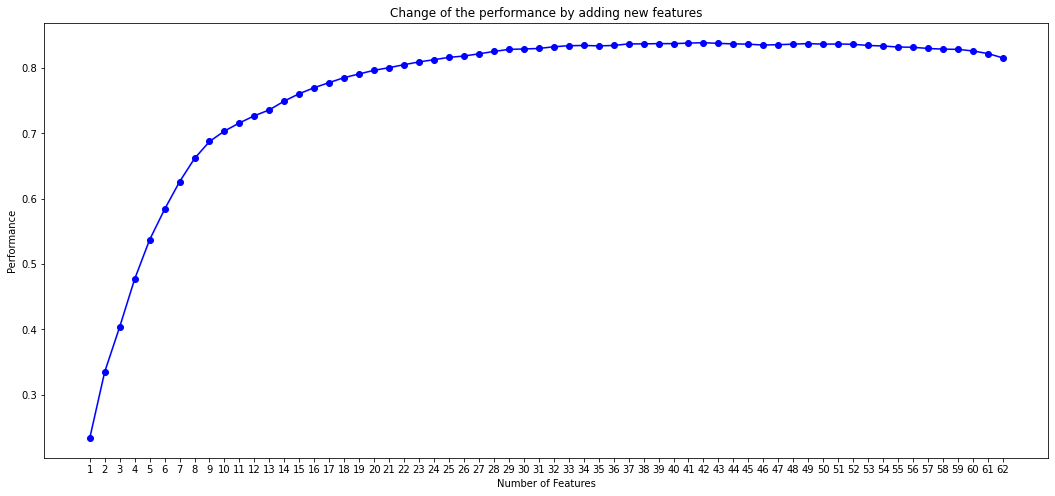

In [83]:
plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(18,8))
plt.title('Change of the performance by adding new features');

In [15]:
bound = 10
x = np.arange(1, bound)
accs = []
for k in range(1, bound):
    sfs = SFS(nbc, 
           k_features=k, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=0)
    sfs = sfs.fit(X_train, y_train)
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    nbc.fit(X_train_sfs, y_train)
    y_pred = nbc.predict(X_test_sfs)

    # Compute the accuracy of the prediction
    acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
    print('Test set accuracy: %.2f %%' % (acc * 100))
    accs.append(acc)

Test set accuracy: 21.00 %
Test set accuracy: 30.76 %
Test set accuracy: 37.60 %
Test set accuracy: 42.72 %
Test set accuracy: 48.88 %
Test set accuracy: 53.60 %
Test set accuracy: 57.16 %
Test set accuracy: 59.88 %
Test set accuracy: 61.80 %


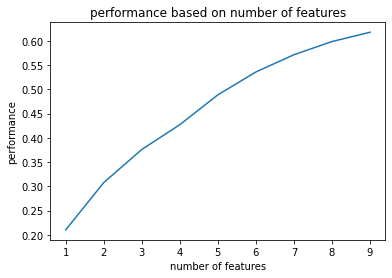

In [17]:
plt.plot(x, accs)
plt.xlabel('number of features')
plt.ylabel('performance')
plt.title('performance based on number of features');

# Problem 10

In [199]:
# calculating within-class scatter matrix:
s_w = np.zeros((X_train.shape[1], X_train.shape[1]))

for i in range(len(class_names)):
    class_data = X_train[np.where(y_train==i)]
    class_mean = np.mean(class_data, axis=0)
    class_scatter = np.dot((class_data - class_mean).T, class_data - class_mean)
    s_w = s_w + class_scatter

(522, 62)